In [1]:
import pickle
import pandas as pd
import numpy as np
from collections import defaultdict
from itertools import cycle

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, plot_roc_curve, roc_auc_score, auc
from sklearn.inspection import permutation_importance
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

from scipy.spatial import distance
from scipy.cluster import hierarchy
import umap
import umap.plot
import networkx as nx
import sys
sys.path.insert(1, '../scripts_other/')
import cs_umap_plot

import matplotlib.pyplot as plt
from bokeh.plotting import show, save, output_notebook, output_file
import seaborn as sns

import time
import datetime

print(datetime.datetime.now())

2023-05-10 08:23:07.125985


In [2]:
path_data = '../data/d20220201/'

# INPUTS
fn_finalSave = path_data + 'featuresAndMeta_s20220720.p'
#fn_trainingResults = path_data + 'trainingResults_binary80_s20230504.p'
fn_featureImp = path_data + 'featureImportance_binaryAll_s20220704.p'

# OUTPUTS

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['font.size'] = 10
plt.rcParams['figure.autolayout']=False

In [3]:
with open(fn_finalSave, "rb") as input_file:
    dict_data = pickle.load(input_file)

dict_data.keys()

dict_keys(['df_rawFeatures_training', 'df_rawFeatures_validation', 'dict_normalizationFactors', 'df_zscoreFeatures_training', 'df_zscoreFeatures_validation', 'df_metadata', 'umap_raw', 'umap_zscore'])

In [4]:
## number of features
dValue = 0.225

# dValue can be modified to retrieve more stringent or relaxed clusters (fewer clusters, increase number)
# 0.25 => 60 features

## load data

In [ ]:
# define current data
currFeatures = dict_data['df_zscoreFeatures_training']
tempMeta = dict_data['df_metadata']
currMeta = tempMeta[tempMeta.index.isin(currFeatures.index)]
currMeta['hvpg_corrected'] = currMeta['hvpg_corrected'].fillna(0).astype(int)
currMeta['hvpg_toPredict'] = currMeta['hvpg_corrected'].apply(lambda x: 0 if x < 10 else 1)

toPredict = currMeta['hvpg_toPredict']

display(currFeatures)
#display(currMeta)

## Feature Selection

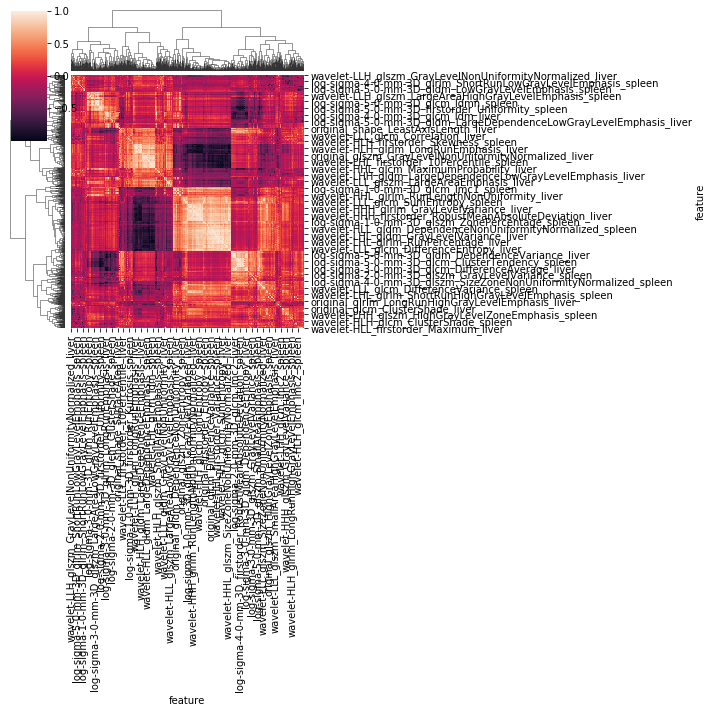

In [6]:
## identify redundant features

# retrieve clusters using fcluster 
df_featcorr = currFeatures.astype(float).corr(method='pearson')
d = hierarchy.distance.pdist(df_featcorr)
L = hierarchy.linkage(d, method='complete')
# dValue can be modified to retrieve more stringent or relaxed clusters (fewer clusters, increase number)
clusters = hierarchy.fcluster(L, dValue*d.max(), 'distance')

# store clusters in dictionary
featCluster_dict = defaultdict(list)
for i,cluster in enumerate(clusters):
    featCluster_dict[cluster].append(df_featcorr.index[i])

currPlt = sns.clustermap(df_featcorr, row_linkage=L, col_linkage=L)

In [7]:
# load feature importances
with open(fn_featureImp, "rb") as input_file:
    forest_importances = pickle.load(input_file)

In [8]:
importances = list(forest_importances)
feat2keep = []
featClusterOrder = []

# list the most influential features
num2list = 10

top_idx = np.argsort(importances)[-num2list:]
top_values = ['{:.4f}'.format(importances[i]) for i in top_idx]

# make data frame to show top features and scores, and display
df_importances = pd.DataFrame({'Feature': currFeatures.columns[top_idx], 'Importance': top_values})

# for each cluster, check which feature is most important, and keep it for downstream model
for eaCluster in featCluster_dict:
    currFeature_i = [currFeatures.columns.get_loc(c) for c in featCluster_dict[eaCluster]]
    currImportances = [forest_importances[c] for c in currFeature_i]
    toKeep_i = currFeature_i[currImportances.index(max(currImportances))]
    feat2keep.append(currFeatures.columns[toKeep_i])
    featClusterOrder.append(eaCluster)    

In [9]:
df_featcorr_2keep = df_featcorr[feat2keep]
df_featcorr_2keep = df_featcorr_2keep[df_featcorr_2keep.index.isin(feat2keep)]

In [10]:
print('total # of features:')
print(len(clusters))
print('# features used for model training:')
print(len(featCluster_dict))

total # of features:
2436
# features used for model training:
80


## Grid search

In [11]:
## Hyperparameter Grid

In [12]:
import numpy as np
np.linspace(10, 110, num = 5)

array([ 10.,  35.,  60.,  85., 110.])

In [13]:
# Number of trees in random forest
n_estimators = [50, 100, 250, 500, 750, 1000, 1500, 2000]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10] 
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
param_grid = {'n_estimators': n_estimators,
              'max_features': max_features,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
              'bootstrap': bootstrap}
param_grid

{'n_estimators': [50, 100, 250, 500, 750, 1000, 1500, 2000],
 'max_features': ['auto', 'sqrt'],
 'max_depth': [10, 35, 60, 85, 110, None],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 2, 4],
 'bootstrap': [True, False]}

In [14]:
features = currFeatures[feat2keep]
labels = toPredict
scoring = {'roc_ovr': 'roc_auc_ovr', 'f1_weighted': 'f1_weighted'}

start_time = time.time()

clf = GridSearchCV(RandomForestClassifier(), 
                   param_grid, 
                   scoring=scoring,
                   refit='roc_ovr',
                   return_train_score=True)
clf.fit(features, labels)

elapsed_time = (time.time() - start_time) / 60
print(f"Elapsed time to run GridCV: {elapsed_time:.1f} minutes")

results = clf.cv_results_

Elapsed time to run GridCV: 272.3 minutes


In [15]:
#results

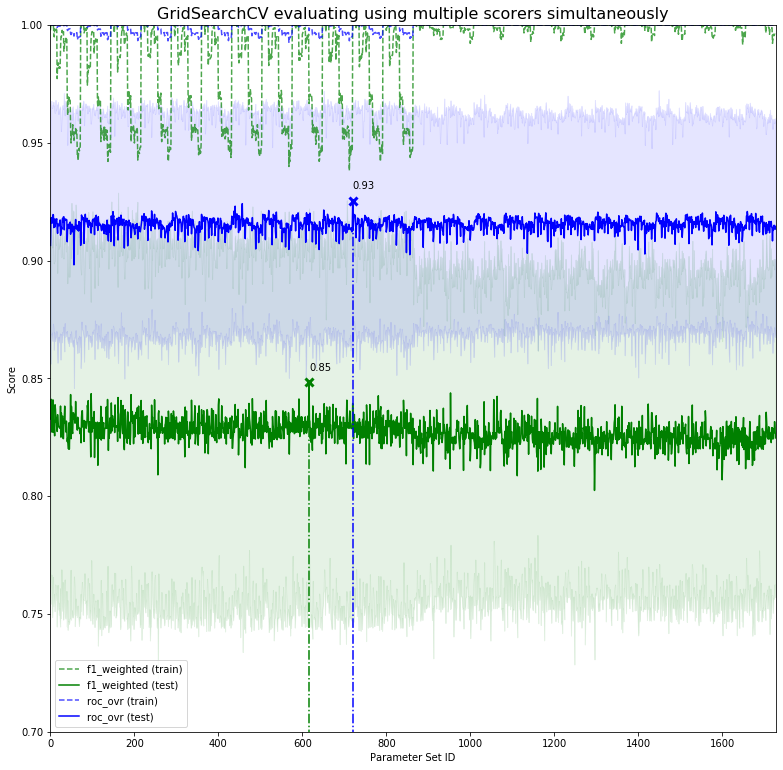

Best parameter set by OVR: {'bootstrap': True, 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}


In [16]:
# from https://scikit-learn.org/stable/auto_examples/model_selection/plot_multi_metric_evaluation.html#sphx-glr-auto-examples-model-selection-plot-multi-metric-evaluation-py

plt.figure(figsize=(13, 13))
plt.title("GridSearchCV evaluating using multiple scorers simultaneously", fontsize=16)

plt.xlabel("Parameter Set ID")
plt.ylabel("Score")

ax = plt.gca()
ax.set_xlim(0, len(results['params']))
ax.set_ylim(0.7, 1)

# Get the regular numpy array from the MaskedArray
X_axis = range(len(results['params']))#np.array(results["param_n_estimators"].data, dtype=float)

for scorer, color in zip(sorted(scoring), ["g", "b", "k"]):
    for sample, style in (("train", "--"), ("test", "-")):
        sample_score_mean = results["mean_%s_%s" % (sample, scorer)]
        sample_score_std = results["std_%s_%s" % (sample, scorer)]
        ax.fill_between(
            X_axis,
            sample_score_mean - sample_score_std,
            sample_score_mean + sample_score_std,
            alpha=0.1 if sample == "test" else 0,
            color=color,
        )
        ax.plot(
            X_axis,
            sample_score_mean,
            style,
            color=color,
            alpha=1 if sample == "test" else 0.7,
            label="%s (%s)" % (scorer, sample),
        )

    best_index = np.nonzero(results["rank_test_%s" % scorer] == 1)[0][0]
    best_score = results["mean_test_%s" % scorer][best_index]

    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot(
        [
            X_axis[best_index],
        ]
        * 2,
        [0, best_score],
        linestyle="-.",
        color=color,
        marker="x",
        markeredgewidth=3,
        ms=8,
    )

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score, (X_axis[best_index], best_score + 0.005))

plt.legend(loc="best")
plt.grid(False)
plt.show()

print('Best parameter set by OVR: ' + str(results['params'][best_index]))

In [17]:
results

{'mean_fit_time': array([0.10210462, 0.20059886, 0.49755197, ..., 2.15070109, 3.22687454,
        4.30685225]),
 'std_fit_time': array([0.0003278 , 0.002755  , 0.00508498, ..., 0.02775582, 0.0475057 ,
        0.08437918]),
 'mean_score_time': array([0.01095862, 0.01752615, 0.03791313, ..., 0.14893203, 0.21095881,
        0.31499209]),
 'std_score_time': array([0.0001133 , 0.00011581, 0.0002248 , ..., 0.01480592, 0.00114889,
        0.0668278 ]),
 'param_bootstrap': masked_array(data=[True, True, True, ..., False, False, False],
              mask=[False, False, False, ..., False, False, False],
        fill_value='?',
             dtype=object),
 'param_max_depth': masked_array(data=[10, 10, 10, ..., None, None, None],
              mask=[False, False, False, ..., False, False, False],
        fill_value='?',
             dtype=object),
 'param_max_features': masked_array(data=['auto', 'auto', 'auto', ..., 'sqrt', 'sqrt', 'sqrt'],
              mask=[False, False, False, ..., False, Fa

In [18]:
print(np.argmax(results['mean_test_f1_weighted']))
print(np.max(results['mean_test_f1_weighted']))
print(results['params'][np.argmax(results['mean_test_f1_weighted'])])

print(np.argmax(results['mean_test_roc_ovr']))
print(np.max(results['mean_test_roc_ovr']))
print(results['params'][np.argmax(results['mean_test_roc_ovr'])])

616
0.8483569688753281
{'bootstrap': True, 'max_depth': 110, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 50}
720
0.9253809364920477
{'bootstrap': True, 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}


In [19]:
features = currFeatures[feat2keep]
labels = toPredict
scoring = {'roc_ovr': 'roc_auc_ovr', 'f1_weighted': 'f1_weighted'}

start_time = time.time()

clf = GridSearchCV(RandomForestClassifier(), 
                   param_grid, 
                   scoring=scoring,
                   refit='roc_ovr',
                   return_train_score=True)
clf.fit(features, labels)

elapsed_time = (time.time() - start_time) / 60
print(f"Elapsed time to run GridCV: {elapsed_time:.1f} minutes")

results = clf.cv_results_

Elapsed time to run GridCV: 272.0 minutes


In [20]:
print(np.argmax(results['mean_test_f1_weighted']))
print(np.max(results['mean_test_f1_weighted']))
print(results['params'][np.argmax(results['mean_test_f1_weighted'])])

print(np.argmax(results['mean_test_roc_ovr']))
print(np.max(results['mean_test_roc_ovr']))
print(results['params'][np.argmax(results['mean_test_roc_ovr'])])

496
0.8517628455212616
{'bootstrap': True, 'max_depth': 85, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 50}
145
0.9243841063285508
{'bootstrap': True, 'max_depth': 35, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [21]:
print(datetime.datetime.now())

2023-05-10 17:27:49.026356
